## 1. Introduction (to European call pricing)

This project focuses on the valuation of a European call option, a financial derivative that gives its holder the right, but not the obligation, to buy an underlying asset at a predetermined strike price $K$ at a maturity time $T$. The price of the call option $C_t$ at time $t$ is given by the formula:

$$C_t = C(S_0, t) = e^{-r(T-t)}\mathbb{E}^Q\left[\max (S_T - K, 0) \right], \quad 0\leq t \leq T$$

whose value is further determined by the following:
+ $S_0$ is the spot price of the underlying asset.
+ $\sigma$ is the volatility of the underlying asset.
+ $r$ is the risk-free interest rate.

In this context, $S_t$ denotes the price of the underlying asset at time $t$, and $\mathcal{Q}$ is the risk-neutral measure used to price the option.

## 2. Option pricing dynamics

### 2.1. Black-Scholes model

The stock price dynamics is given by $S_t = S_0 e^{\left(r - \frac{1}{2}\sigma^2\right)t + \sigma W_t}$ where $W_t$ is a $\mathcal{Q}$-Brownian motion.

The class `GBM` below implements the stock process, sample path and the characteristic function of $\ln S_t$ which is used in the subsequent Fourier pricing methods. The sample path is implemented by using a cumulative sum of the increments of the Brownian motion:
$$W\left(t_k\right)=\Delta W_k+W\left(t_{k-1}\right)=\sum_{j=1}^k \Delta W_j, k = 1, ..., N$$

In [33]:
import numpy as np
import matplotlib.pyplot as plt

class GBM:
    """
    Initialises the GBM model

    Parameters
    ----------
    S0 : float
        Initial stock price
    r : float
        Risk-free interest rate
    sigma : float
        Volatility of the stock price process
    """
    def __init__(self, S0, r, sigma):
        self.S0 = S0
        self.r = r
        self.sigma = sigma
    
    def phi(self, t, u):
        """
        Evaluates the characteristic function of log(St), where St is the
        stock price given by a Geometric Brownian motion

        Parameters
        ----------
        t : array_like(float, ndim=1)
            Time of log-stock price for charateristic function to be computed;
            usually the maturity of the call option

        u : array_like(float, ndim=1)
            Value at which the characteristic function of log(St) is to be
            computed

        Returns
        -------
        phi_t(u) : array_like(float, ndim=1)
            Value of characteristic function of log(St) computed at u.
        """
        S0, r, sigma = self.S0, self.r, self.sigma
        mu = np.log(S0) + (r - 0.5*sigma**2)*t
        var = t*sigma**2
        return np.exp(1j*u*mu  - 0.5*u**2*var)
    

    def sample_path(self, T, N = 200, plot=False):
        """
        Generates sample path of the GBM model and returns terminal price

        Parameters
        ----------
        plot : bool, optional
            If true, plots and displays the generated sample path
        
        T : float
            Time to maturity
        
        N : int, optional
            Number of subintervals in the time discretisation

        Returns
        -------
        ST : float
            The simulated value of the terminal stock price at time T
        """
        dt = T/N
        t = np.linspace(0, T, N + 1)
        dW = np.random.normal(0, np.sqrt(dt), N)
        W = np.insert(np.cumsum(dW), 0, 0)

        S0, r, sigma = self.S0, self.r, self.sigma
        S_sim = S0 * np.exp((r - 0.5*sigma**2)*t + sigma*W)

        if plot:
            plt.plot(t, S_sim)
            plt.xlabel('Time $(t)$')
            plt.ylabel('Stock Price $(S_t)$')
            plt.title('Sample path of GBM ($S_0 = {}, r = {}, \sigma = {}$)'.format(S0, r, sigma))
            plt.show()
        return S_sim[-1]

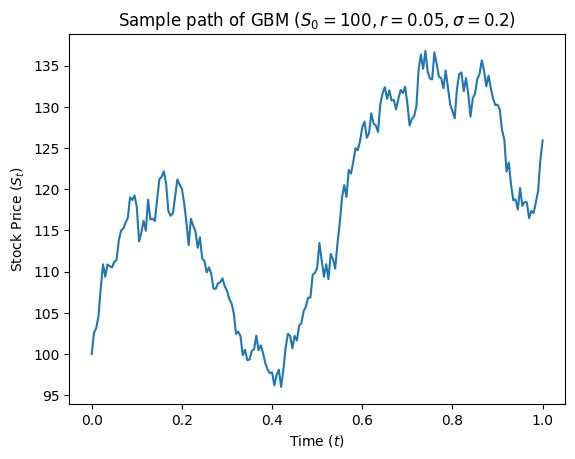

125.93115241587958

In [34]:
# Set the seed for reproducibility
np.random.seed(0)

# Create instance of the GBM model with S0=100, r=0.05, sigma=0.2
GBM(100, 0.05, 0.2).sample_path(T=1, plot=True)

#### 2.2. Variance Gamma model

The VG model accounts for some shortcomings of the Black-Scholes model by accounting for more complex dynamics such as skewness and kurtosis in asset returns, captures the (empirically observed) leptokurtic nature of log-returns, and allows for jumps and irregularities in asset prices.

The price dynamics for the model is given by:

$$S_t = S_0 e^{rt + X_t (\theta, \sigma, \nu) + \omega t}$$

where $X_t (\theta, \sigma, \nu)$ is a Variance Gamma process. The sample path is implemented by the algorithm presented by Korn et al. (2010):

$$X\left(t_k\right)=X\left(t_{k-1}\right)+\theta \Delta G_k+\sigma \sqrt{\Delta G_k} Z_k=\theta \sum_{j=1}^k \Delta G_k+\sigma \sum_{j=1}^k \sqrt{\Delta G_j} Z_j, \quad k=1,...,N$$
where $\Delta G_i \sim \Gamma(\frac{dt}{\nu}, \nu)$ and $Z_i \sim N(0, 1)$ for $i = 1, ..., N$.

In [35]:
class VarianceGamma:
    """
    Initialises the Variance-Gamma process.

    Parameters
    ----------
    S0 : float
        Initial stock price
    
    r : float
        Risk-free interest rate
    
    sigma : float
        Volatility parameter of VG process
    
    theta : float
        Drift parameter of VG process
    
    nu : float
        Variance rate parameter of Gamma process 
    
    omega : float, optional
        Drift correction term. Default value is
            ω = 1/ν log(1 - θν - 0.5νσ^2),
        which ensures the stock's expected return is equal to the continuously
        compounded risk free rate r
    """
    def __init__(self, S0, r, sigma, theta, nu, omega=None):
        self.S0 = S0
        self.r = r
        self.sigma = sigma
        self.theta = theta
        self.nu = nu

        if omega is None:
            omega = (1/nu) * np.log(1 - theta*nu - 0.5*nu*sigma**2)
        self.omega = omega
    
   
    def phi(self, t, u):
        """
        Evaluates the characteristic function of log(St), where St is the
        stock price given by a Variance-Gamma process.

        Parameters
        ----------
        t : array_like(float, ndim=1)
            Time of log-stock price for charateristic function to be computed;
            usually the maturity of the call option.

        u : array_like(float, ndim=1)
            Value at which the characteristic function of log(St) is to be
            computed.

        Returns
        -------
        phi_t(u) : array_like(float, ndim=1)
            Value of characteristic function of log(St) computed at u. 
        """
        S0, theta, sigma, nu = self.S0, self.theta, self.sigma, self.nu
        r, omega = self.r, self.omega
        denom = np.power((1 - 1j*theta*nu*u + 0.5*(u*sigma)**2*nu), t/nu)
        return np.exp(1j*u*(np.log(S0) + (r + omega)*t)) / denom
    

    def sample_path(self, T, N=200, plot=False):
        """
        Generate a sample path of stock based on the Variance-Gamma process
        and return the terminal stock price.

        Parameters
        ----------
        plot : bool, optional
            If true, plots and displays the generated sample path.
        
        T : float
            Time to maturity.

        N : int, optional
            Number of subintervals in the time discretisation

        Returns
        -------
        ST : float
            The simulated value of the terminal stock price at time T.
        """
        S0, r, sigma, theta, nu = self.S0, self.r, self.sigma, self.theta, self.nu
        omega = self.omega

        dt = T/N
        t = np.linspace(0, T, N+1)
        Z = np.random.normal(0, 1, N)

        dG = np.random.gamma(dt/nu, nu, N)
        X = theta*np.cumsum(dG) + sigma*np.cumsum(np.sqrt(dG)*Z)
        X = np.insert(X, 0, 0)    # Set X_0 = 0
        S_sim = S0 * np.exp((r + omega)*t + X)

        if plot:
            plt.plot(t, S_sim)
            plt.xlabel('Time $(t)$')
            plt.ylabel('Stock Price $(S_t)$')
            plt.title(r'Sample path of VG ($S_0 = {}, r = {}, \sigma = {}, \theta = {}, \nu = {}$)'.format(S0, r, sigma, theta, nu))
            plt.show()

        return S_sim[-1]

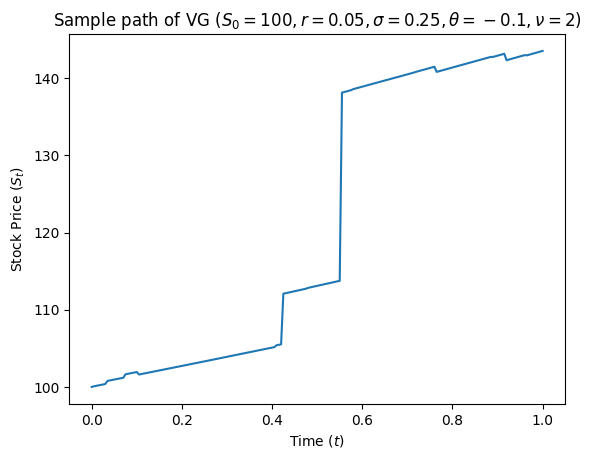

143.52569254439322

In [36]:
# Set the seed for reproducibility
np.random.seed(0)

# Create instance of the VG model with S0=100, r=0.05, sigma=0.25, theta=-0.1, nu=2
VarianceGamma(100, 0.05, 0.25, -0.1, 2).sample_path(T=1, plot=True)

## 3. Option Pricing Methods

The class `EuCall` below implements a European call option that takes in a stock process (either GBM or VG), the strike price and the maturity time.

The option pricing methods will be incrementally implemented in this class across the notebook.

In [37]:
class EuCall:

    def __init__(self, S, K, T):
        """
        Instantiates a European Call option given a stock process

        Parameters
        ----------
        K : float
            Strike price of the call option
        
        T : float
            Time to maturity of the call option
        
        S : GBM or VarianceGamma
            Stock process model
        """
        self.S = S
        self.K = K
        self.T = T
    
    def payoff(self, ST):
        """
        Evaluates the payoff of the call option at maturity

        Parameters
        ----------
        ST : float
            Terminal stock price

        Returns
        -------
        payoff : float
            Value of the call option at maturity
        """
        return max(ST - self.K, 0)

### 3.1. Black-Scholes analytical price

The closed-form solution for the European call price under BS dynamics is given by:

$$C_0 = S_0 \Phi(d_1) - K e^{-rT} \Phi(d_2)$$

where $\Phi$ is the CDF of the standard normal distribution. The $d_1$ and $d_2$ terms are defined as:
$$d_1 = \frac{\log(\frac{S_0}{K}) + (r + \frac{\sigma^2}{2})T}{\sigma \sqrt{T}}, \quad d_2 = d_1 - \sigma \sqrt{T}$$

### 3.2. Variance Gamma analytical price

The solution for the European call price under VG dynamics is presented in Carr, Chang and Madan (1998, Pg 88):

$$C_0 = S_0 \Psi\left(d \sqrt{\frac{1-c_1}{v}},(\alpha+s) \sqrt{\frac{v}{1-c_1}}, \frac{T}{v}\right) - K e^{-rT} \Psi\left(d \sqrt{\frac{1-c_2}{v}}, \alpha s \sqrt{\frac{v}{1-c_2}}, \frac{T}{v}\right)$$

where
+ $d=\frac{1}{s}\left[\ln \left(\frac{S_0}{K}\right)+r T+\frac{T}{v} \ln \left(\frac{1-c_1}{1-c_2}\right)\right], \quad \zeta=-\frac{\theta}{\sigma^2}, \quad s=\frac{\sigma}{\sqrt{1+\left(\frac{\theta}{\sigma}\right)^2 \frac{v}{2}}}$

+ $\alpha = \zeta s, \quad c_1=\frac{\nu(\alpha+s)^2}{2}, \quad c_2=\frac{v \alpha^2}{2}$

$\Psi$ has an extremely complicated closed-form solution defined in terms of the modified bessel function of the second kind and the degenerate hypergeometric function of two variables. Due to difficulty in implementation, the following integral representation is used:

$$\Psi(a, b, \gamma)=\int_0^{\infty} \Phi \left(\frac{a}{\sqrt{u}}+b \sqrt{u}\right) \frac{u^{\gamma-1} e^{-u}}{\Gamma(\gamma)} d u$$

However, it is observed that the singularity at $u=0$ introduces inaccuracies and renders the theoretical price difficult to compute, especially for ATM/OTM calls. This will be further addressed in section 4.

In [38]:
from scipy.stats import norm
from scipy.integrate import quad
from scipy.stats import gamma

class EuCall(EuCall):

    def price(self):
        """
        Calculates price of the European call using appropriate method
        
        Returns
        -------
        price : float
            Price of the European call option
        """
        if isinstance(self.S, GBM):
            return self._price_gbm()
        elif isinstance(self.S, VarianceGamma):
            return self._price_variance_gamma()
        else:
            raise ValueError("Unsupported stock process model")
    
    def _price_gbm(self):
        """
        Calculates price of (GBM) European call option

        Returns
        -------
        price : float
            Price of the European call option
        """

        S, K, T = self.S, self.K, self.T
        S0, r, sigma = S.S0, S.r, S.sigma

        d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / sigma*np.sqrt(T)
        d2 = d1 - sigma*np.sqrt(T)
        
        delta = norm.cdf(d1)
        probITM = norm.cdf(d2)

        return S0*delta - K*np.exp(-r*T)*probITM
    
    def _price_variance_gamma(self):
        """
        Calculates price of (VG) European call option

        Returns
        -------
        price : float
            Price of the European call option
        """
        S, K, T = self.S, self.K, self.T
        S0, r, sigma, theta, nu = S.S0, S.r, S.sigma, S.theta, S.nu

        zeta = - theta / sigma**2
        s = sigma / np.sqrt(1 + 0.5 * nu * (theta/sigma)**2)
        alpha = zeta * s

        c1 = 0.5 * nu * (alpha + s)**2
        c2 = 0.5 * nu * alpha**2

        log_term = np.log((1-c1)/(1-c2))
        d = 1/s * (np.log(S0/K) + r*T + (T/nu) * log_term)

        def Psi(a, b, c):
            def Psi_integrand(u, a, b, c):
                return norm.cdf(a / np.sqrt(u) + b * np.sqrt(u)) * gamma.pdf(u, a=c)

            # Perform the integration from 0 to infinity
            I, _ = quad(Psi_integrand, 0, np.inf, args=(a, b, c))
            
            return I

        a1 = d * np.sqrt((1-c1)/nu)
        b1 = (alpha+s) * np.sqrt(nu/(1-c1))
        c = T/nu

        a2 = d * np.sqrt((1-c2)/nu)
        b2 = alpha * s * np.sqrt(nu/(1-c2))
        
        delta = Psi(a1, b1, c)
        probITM = Psi(a2, b2, c)

        return S0*delta - K*np.exp(-r*T)*probITM

### 3.3. Monte Carlo simulation

The Monte Carlo method simulates numerous possible stock paths and calculates the average payoff at maturity.

It is most useful when the analytical solution is difficult to obtain and also provides a useful benchmark to compare the pricing methods. The formula is given by:

$$\hat{C}_0 = e^{-rT} \cdot \frac{\sum_{i=1}^N \max(S^{(i)}_T - K, 0)}{N}$$

where $S^{(i)}_T$ is the $i$-th simulated stock price at maturity and $N$ is the number of simulations.

In [39]:
class EuCall(EuCall):

    def monte_carlo_price(self, n=1000):
        """
        Computes the price of the call option using Monte Carlo simulation.

        Parameters
        ----------
        n : int
            Number of sample paths of the stock price to simulate.
        
        Returns
        -------
        C0 : float
            Call price approximated by averaging the discounted terminal 
            payoffs of the call option across the n simulations.
        """
        r, T = self.S.r, self.T
        total_payoff = sum(self.payoff(self.S.sample_path(T)) for _ in range(n))

        return 1/n * np.exp(-r*T) * total_payoff

### Fourier methods

We now implement the Fourier methods that are able to be used by both GBM and VG models.

### 3.3. Review of Fourier method (inversion method)

Given the terminal spot price $S_T$, the characteristic function of $s_T = \ln S_T$ is defined as:

$$\phi_T(u) = \mathbb{E}[e^{iu s_T}] = \mathbb{E}[e^{iu \ln S_T}]$$

Assuming that the characteristic function is known analytically, the option price can be determined as (assuming no dividends and interest rates are constant):

$$C_0 = S_0 \Pi_1 - K e^{-rT} \Pi_2$$

where the delta of the option ($\Pi_1$) and risk-neutral probability of finishing in the money ($\Pi_2$) are given by (Bakshi and Madan 1999, Scott 1997):

$$\Pi_1:=\frac{1}{2}+\frac{1}{\pi} \int_0^{\infty} \text{Re}\left(\frac{e^{-i u \ln K} \phi_T(u-i)}{i u \phi_T(-i)}\right) d u$$

$$\Pi_2:=\mathbb{P}\left(S_T>K\right)=\frac{1}{2}+\frac{1}{\pi} \int_0^{\infty} \operatorname{Re}\left(\frac{e^{-i u \ln K }\phi_T(u)}{i u}\right) d u$$

However, the integrals cannot be evaluated using since the integrand is singular at $u=0$. The next section will address this shortcoming.

In [40]:
import warnings
from scipy.integrate import quad, IntegrationWarning

# Suppress the specific IntegrationWarning
warnings.filterwarnings("ignore", category=IntegrationWarning)

class EuCall(EuCall):

    def FTPrice(self, lower=0, upper=np.inf, weight=None, wvar=None):
        """
        Compute the price of the call option using the Fourier methods on
        page 2 of Carr and Madan 1999.

        Parameters
        ----------
        lower : float, optional
            The lower integration limit. Default value is 0. Due to the
            singularity at 0, a small positive eps may help performance.

        upper : float, optional
            The upper integration limit. Default value is np.inf.
            If weight='cauchy' (see below), finite upper bound must be
            specified.

        weight : str, optional
            Specify the weight function for scipy to use in calculating the
            integral. Due to singularity at 0, weight='cauchy' may help
            performance.

        wvar : float or tuple, optional
            Variables associated with the weight used. Since the singularity
            is at 0, wvar is automatically set to 0 when using Cauchy weights.

        Returns
        -------
        C0 : float
            Call price computed using the Fourier methods to calculate the
            delta and the probability of finishing in the money (PrITM).
            The option price is then given by
                C0 = S0*Delta - Ke^{-rT}*PrITM.
        """
        S0, r, K, T = self.S.S0, self.S.r, self.K, self.T
        k = np.log(K) 
        phi = self.S.phi

        # Integrand for FTM probability
        def probITMIntegrand(u):
            return np.real(-1j*(np.exp(-1j*u*k) * phi(T, u)) / u)
        
        # Integrand for delta
        def deltaIntegrand(u):  
            numerator = -1j * (np.exp(-1j*u*k) * phi(T, u - 1j))
            return np.real(numerator / (u*phi(T, -1j)))

        # Compute the integrals
        if weight == "cauchy":
            wvar = 0

        intITM, _ = quad(probITMIntegrand, a=lower, b=upper, weight=weight, wvar=wvar)
        intDelta, _ = quad(deltaIntegrand, a=lower, b=upper, weight=weight, wvar=wvar)
        probITM = 0.5 + intITM/np.pi
        delta = 0.5 + intDelta/np.pi

        return S0*delta - K*np.exp(-r*T)*probITM

### 3.4. The Fast Fourier Transform

The Carr-Madan FFT method first seeks to modify the call price formula. Letting $k = \ln K$, $s_t = \ln S_t$ and $\phi_T(u) = \mathbb{E}[e^{iu s_T}]$, the modified call price is given by:

$$c_T (k) = e^{\alpha k} C_T(k)$$

for some appropriately chosen $\alpha>0$ that ensures $c_T(k)$ is square-integrable in $k$ over the real line. This resolves the aforementioned singularity issues at $u=0$.

Now letting $\psi_T$ denote the Fourier transform of $c_T(k)$ and by using the inverse transform, we have the call price:

$$C_T (k) = \frac{e^{-\alpha k}}{\pi} \int_0^{\infty} e^{-i u k} \psi_T(u) du  \quad (\dagger)$$

where $\psi_T$ is further derived to be:

$$\psi_T(v) = \int_{-\infty}^{\infty} e^{-i v k} c_T(k) dk = \frac{e^{-r T} \phi_T(v-(\alpha+1) i)}{\alpha^2+\alpha-v^2+i(2 \alpha+1) v}$$

The FFT algorithm is then used for the integral in $(\dagger)$. Defining a uniform partition of $N$ points where $v_j=\eta j$ for $j=0,\ldots,N-1$ and spacing size $\eta$ (upper limit of integration is $N \eta$), use Simpson's rule weights to increase accuracy and a range of log-strikes defined by

$$
k_u=-b+\lambda u, \quad \text { for } u=0,\ldots,N-1,
$$

where $b=\frac{1}{2} N \lambda$ and $\lambda \eta=\frac{2 \pi}{N}$. The FFT can be directly applied to compute a range of call prices.

$$
C\left(k_u\right) \approx \frac{e^{-\alpha k_u}}{\pi} \sum_{j=0}^{N-1} e^{-\frac{2 iju \pi}{N}} e^{i b v_j} \psi_T\left(v_j\right) \frac{\eta}{3}\left(3+(-1)^{j+1}-\delta_{j}\right), \quad \delta_j = \begin{cases} 1 & \text{if } j=0 \\ 0 & \text{otherwise} \end{cases}
$$

The drawback of this method is the requirement of a predefined strike-price spacing, not only is it difficult to calculate call prices for arbitrary strikes, but most of the prices are not useful (these options are very far in or out-of the money).

In [41]:
from scipy.fft import fft

def MCallFTo(S, T, v, alpha):
    """Compute the Fourier transform of the modified call.

    Parameters
    ----------
    S : VarianceGamma or GeometricBrownianMotion
        The Stock price process of the call option.

    T : float
        Time to maturity of the call option.

    v : float
        Value at which to compute the Fourier Transform.
    
    alpha : float
        The modification parameter used in defining the modified call.
    
    Returns
    -------
    Psi : float
        The Fourier transform, Psi_{T}(v), of the modified call price
            c_{T}(k) = e^{alpha*k}*C_{T}(k),
        evaluated at v.
    """
    denom = (alpha**2+alpha-v**2) + (2*alpha+1)*v*1j
    return np.exp(-S.r*T)*S.phi(T, v - (alpha+1)*1j) / denom


def logStrikePartition(eta = 0.25, N = 4096):
    """
    Creates a partition of strike prices in the log-space for use in the
    FFT pricing functions.

    Parameters
    ----------
    eta : float, optional
        The spacing size used in the quadrature of the modified call's Fourier
        transform. Default value is 0.25 from Carr and Madan 1999.
    
    N : int, optional
        The number of points used in the quadrature of the modified call's
        Fourier transform. Defaul value is 2**12 = 4096 from Carr and Madan
        1999. Note, N should be a power of 2 for ideal performance in the fft.

    Returns
    -------
    b : float
        See description of k.
    lamb : float
        See description of k.
    k : array_like(float, ndim=1)
        Numpy array with N strike prices in the log space uniformly spaced in
        the interval [-b, b). lamb is the spacing size between log-strikes 
        in k.
    """
    b = np.pi/eta
    lamb = 2*np.pi/(eta*N)
    k = -b + lamb*np.arange(0, N)
    return (b, lamb, k)


def FFTPrice(S, T, L = 0, U = np.inf, alpha = 1.5, eta = 0.25, N = 4096):
    """
    Computes an array of call option prices using the FFT method described
    in Carr and Madan 1999.

    Parameters
    ----------
    S : VarianceGamma or GeometricBrownianMotion
        The Stock price process of the call option.

    T : float
        Time to maturity of the call option.
    
    L : float, optional
        Function returns call prices only for strikes between L and U.
        The default values are L = 0 and U = np.inf, so call prices for all
        strikes are returned unless otherwise specified.

    U : float, optional
        See above.
    
    alpha : float
        The modification parameter used in defining the modified call. See
        CMFT price for detailed description.
    
    eta : float, optional
        The spacing size used in the quadrature of the modified call's Fourier
        transform. Default value is 0.25 from Carr and Madan 1999.

    N : int, optional
        The number of points used in the quadrature of the modified call's
        Fourier transform. Defaul value is 2**12 = 4096 from Carr and Madan
            1999. Note, N should be a power of 2 for ideal performance in the fft.
    
    Returns
    -------
    callPrices : array_like(float, ndim=1)
        Call prices calculated using the FFT approach for strike prices
        between L and U.
    """
    # Create integration partition
    V = np.arange(0, N*eta, eta)

    # Create log-strike partition
    kPart = logStrikePartition(eta, N)
    b, k = kPart[0], kPart[2]

    # Compute Simpson's rule weights
    pm_one = np.empty((N,))
    pm_one[::2] = -1
    pm_one[1::2] = 1
    Weights = 3 + pm_one
    Weights[0] -= 1  # Kronecker Delta on the first weight
    Weights = (eta/3) * Weights

    # Sequence to apply Fourier transform
    x = np.exp(1j*b*V) * MCallFTo(S, T, V, alpha) * Weights
    callPrices = np.real((np.exp(-alpha*k)/np.pi) * fft(x))

    # Return only the prices with strikes between L and U
    kIndices = np.logical_and(np.exp(k)>L, np.exp(k)<U)
    return callPrices[kIndices]

## 4. Analysis

Now we wish to compare the accuracy and efficiency of the FFT method. Accurate pricing requires good estimate of the model parameters which is generally obtained through calibration to market data. Following the example set in Carr and Madan's paper, we have the following parameters:

+ GBM: $S_0=100, r=0.05, \sigma = 0.1, T = 1$.
+ VG: $S_0=100, r=0.05, \sigma = 0.25, \theta = -0.1, \nu = 2, T=1$.

We obtain the prices of the methods for a range of strikes and compare them to the analytical solution, also calculating the relative error of each method.

### 4.1. Black-Scholes model

In [54]:
import pandas as pd

K, T = 140, 1
S0, r, sigma = 100, 0.05, 0.2

GBM_stock = GBM(S0, r, sigma)
GBM_call = EuCall(GBM_stock, K, T)

# FFT Price Parameters, using the defaults from Carr and Madan 1999.
alpha, eta, N = 1.5, 0.25, 4096

# Get strikes between L and U
L, U = 50, 150
_, _, k = logStrikePartition(eta, N)
K = np.exp(k)
K = np.array([strike for strike in K if strike > L and strike < U])

prices = []
for (i, strike) in enumerate(K):
    GBM_call.K = strike
    prices.append([strike,
                   GBM_call.price(),
                   GBM_call.monte_carlo_price(),
                   GBM_call.FTPrice(),
                   FFTPrice(GBM_stock, T, L, U)[i]])

GBM_prices = pd.DataFrame(prices, columns=['Strike price', 'Analytic', 'Monte Carlo', 'Inversion', 'FFT'])
GBM_prices

,Strike price,Analytic,Monte Carlo,Inversion,FFT
0,50.134980,52.310485,52.202747,52.310485,52.310485
1,50.443550,52.017013,51.594047,52.017013,52.017013
2,50.754020,51.721741,50.536433,51.721741,51.721741
3,51.066400,51.424659,52.620707,51.424659,51.424658
4,51.380702,51.125756,50.742856,51.125756,51.125755
...,...,...,...,...,...
174,145.819506,0.500795,0.558488,0.500795,0.500795
175,146.716994,0.466690,0.501981,0.466690,0.466690
176,147.620006,0.434584,0.409155,0.434584,0.434584
177,148.528576,0.404383,0.277992,0.404383,0.404383


In [61]:
def get_rel_error(expected, actual):
    return (100*abs(expected - actual) / expected).mean()

GBM_rel_errors = {'Method': ['Monte Carlo', 'Inversion', 'FFT'],
                  'Relative Error (%)': [get_rel_error(GBM_prices['Analytic'], GBM_prices['Monte Carlo']),
                                        get_rel_error(GBM_prices['Analytic'], GBM_prices['Inversion']),
                                        get_rel_error(GBM_prices['Analytic'], GBM_prices['FFT'])]}

GBM_rel_errors = pd.DataFrame(GBM_rel_errors)
GBM_rel_errors

,Method,Relative Error (%)
0,Monte Carlo,4.378901e+00
1,Inversion,6.518550e-11
2,FFT,5.723768e-06


It is observed that the Fourier Inversion method is the most accurate, followed by the FFT method and the Monte Carlo method. The inversion method retains high precision since it directly inverts the characteristic function and does not rely on discretisation or truncation which introduces small numerical errors. 

However, it is shown shortly that the FFT is significantly faster than the inversion method so a trade-off between accuracy and efficiency must be made.

### 4.2. VG model

In [43]:
K, T = 140, 1
S0, r, sigma, theta, nu = 100, 0.05, 0.25, -0.1, 2

VG_stock = VarianceGamma(S0, r, sigma, theta, nu)
VG_call = EuCall(VG_stock, K, T)

In [62]:
# FFT Price Parameters, using the defaults from Carr and Madan 1999.
alpha, eta, N = 1.5, 0.25, 4096

# Get strikes between L and U
L, U = 50, 150
k = logStrikePartition(eta, N)[2]
K = np.exp(k)
K = np.array([strike for strike in K if strike > L and strike < U])

prices = []
for (i, strike) in enumerate(K):
    VG_call.K = strike
    prices.append([strike,
                   VG_call.price(),
                   VG_call.monte_carlo_price(),
                   VG_call.FTPrice(),
                   FFTPrice(GBM_stock, T, L, U)[i]])

VG_prices = pd.DataFrame(prices, columns=['Strike price', 'Analytic', 'Monte Carlo', 'Inversion', 'FFT'])

VG_prices

,Strike price,Analytic,Monte Carlo,Inversion,FFT
0,50.134980,52.837921,52.142431,52.665456,52.310485
1,50.443550,52.562355,52.538650,52.394615,52.017013
2,50.754020,52.285586,51.622420,52.031532,51.721741
3,51.066400,52.007621,51.668178,51.773118,51.424658
4,51.380702,51.728469,51.659125,51.537864,51.125755
...,...,...,...,...,...
174,145.819506,11.338869,0.999087,0.979174,0.500795
175,146.716994,11.218546,0.887333,0.954250,0.466690
176,147.620006,11.099419,0.852976,0.917447,0.434584
177,148.528576,10.981479,0.924987,0.885815,0.404383


We observe an immediate difficulty in obtaining a benchmark for the VG model. The VG methods show similar prices for lower $K$ values but exhibit a considerable variance for higher $K$ values. In particular, for $K = 149$ (last row) the analytical method yield a price of $10.86$ while the other methods remain under $1$, suggesting a significant inaccuracy in the analytical method.

It appears that Monte Carlo and Fourier methods are the only viable methods for VG pricing. Considering the speed advantage of the FFT method, the only VG method reasonable for practical use would be the FFT method.

#### Time analysis

The cell below compares the time taken to compute the option price using the analytical BS and VG methods, the Monte Carlo simulation, inversion method and the FFT method (averaged over 100 runs). The FFT method will be used to compute the option price for a range of strikes.

In [46]:
import time

RUNS = 100

def time_method(method, *args, runs=RUNS):
    """Measure the execution time of a pricing method over a given number of runs."""
    start = time.process_time()
    for _ in range(runs):
        method(*args)
    end = time.process_time()
    return end - start

# Initialize dictionary to store results
timing_results = {
    "Pricing Method": ["Analytical", "Monte Carlo", "Fourier inversion", "Fast Fourier Transform"],
    "Avg time for GBM (s)": [],
    "Avg time for VG (s)": []
}

# Timing for GBM
timing_results["Avg time for GBM (s)"].append(time_method(GBM_call.price) / RUNS)
timing_results["Avg time for GBM (s)"].append(time_method(GBM_call.monte_carlo_price) / RUNS)
timing_results["Avg time for GBM (s)"].append(time_method(GBM_call.FTPrice) / RUNS)
timing_results["Avg time for GBM (s)"].append(time_method(FFTPrice, GBM_stock, T, L, U) / RUNS)

# Timing for VG
timing_results["Avg time for VG (s)"].append(time_method(VG_call.price) / RUNS)
timing_results["Avg time for VG (s)"].append(time_method(VG_call.monte_carlo_price) / RUNS)
timing_results["Avg time for VG (s)"].append(time_method(VG_call.FTPrice) / RUNS)
timing_results["Avg time for VG (s)"].append(time_method(FFTPrice, VG_stock, T, L, U) / RUNS )

timing_results = pd.DataFrame(timing_results)
timing_results

,Pricing Method,Avg time for GBM (s),Avg time for VG (s)
0,Analytical,0.000088,0.017225
1,Monte Carlo,0.018098,0.026785
2,Fourier inversion,0.001091,0.011479
3,Fast Fourier Transform,0.000242,0.000363


The FFT method is significantly faster than the other methods (except for the BS analytical method), even with the calculation of a range of strikes. 
Monte Carlo simulation is the slowest and most computationally expensive method, rendering it impractical for real-time option pricing despite its potential accuracy in more complex scenarios. As more complex dynamics and modifications are introduced, the FFT method will become more advantageous in terms of both accuracy and efficiency.

## References

1. Carr, P, Madan, D.B, 1999, “Option Valuation using the Fast Fourier Transform”, Journal of Computational Finance, 2, 61-63.

2. Carr, P., Chang, E., & Madan, D. (1998). The Variance Gamma Process and Option Pricing. European Finance Review, 2(1), 79–105.

3. Korn, E, Korn, R, 2010, “Monte-Carlo Methods and Models in Finance and Insurance”, Chapman and Hall/CRC, Section 7.3.3

